In [1]:
import pickle, os
import sys
import numpy as np
import torch
import matplotlib.pyplot as plt
import pdb

%load_ext autoreload
%autoreload 2

In [2]:
sys.path.append('CONFIG_files/')

In [3]:
import CONFIG_eLLOiWHFRq as CONFIG

CONFIG.REGION

'COMBINED'

In [4]:
run_prefix = 'JRxdlLZMjY'

with open(f'/data/hpcdata/users/marron31/_experiments/{run_prefix}/importance.pkl', 'rb') as handle:
    importance = pickle.load(handle, )


In [5]:
def create_k_all_importance(importance, CONFIG):
    # Create importance for k_all
    for run in importance.keys():
        for k in range(len(CONFIG.params['k'])):
            if k == 0:
                importance[run]['k_all'] = {}
            
            for j in range(len(importance[run][f'k{k}'].keys())):
                if k==0: 
                    importance[run]['k_all'][f'{j:.0f}'] = importance[run][f'k{k}'][f'{j:.0f}']
                else:
                    importance[run]['k_all'][f'{j:.0f}'] = torch.concat([importance[run]['k_all'][f'{j:.0f}'],importance[run][f'k{k}'][f'{j:.0f}']])

In [6]:
create_k_all_importance(importance, CONFIG)

In [7]:
# importance['VGLM_[]_bgmm_B=128_D=0']['k_all']['0'].shape
# importance['VGLM_[]_bgmm_B=128_D=0']['k_all']['1'].shape
# importance['VGLM_[]_bgmm_B=128_D=0']['k_all']['2'].shape

In [12]:
# Helper method to print importances and visualize distribution
def visualize_importances(feature_names, attr, title="Average Feature Importances", plot=True, axis_title="Features", plot_error_bars=False):
    
    attr = attr.detach().numpy()
    
    importances = np.mean(attr, axis=0)
    error_bars = np.stack([-np.quantile(attr, 0.1, axis=0),np.quantile(attr, 0.9, axis=0)])
                          
    # print(title)
    for i in range(len(feature_names)):
        pass
        #print(feature_names[i], ": ", f"{importances[i]:.3f} {error_bars[0,i]:.3f} {error_bars[1,i]:.3f}")
    x_pos = (np.arange(len(feature_names)))
    if plot:
        plt.figure(figsize=(18,4))
        if plot_error_bars:
            plt.bar(x_pos, importances,yerr=error_bars, align='center',capsize=10, color='black', ecolor='black', width=0.5)
        else:
            plt.bar(x_pos, importances,align='center',capsize=10, color='black',)    

        plt.xticks(x_pos, feature_names, wrap=False, rotation=90)
        plt.xlabel(axis_title)
        plt.title(title)
        plt.grid()
        plt.show()
        

def plot_multiple_bars(importances, feature_names):
    
    plt.figure(figsize=(25,4))
    # width = 1/len(importances)
    width = 1/len(importances)*0.8
    
    for i in range(len(importances)):
        attr = importances[i].detach().numpy()
        attr = np.mean(attr, axis=0)
#         pdb.set_trace()
        x_pos = np.arange(attr.shape[0])
        plt.bar(x_pos - 0.5*0.8 + i * width, attr, width=width)
    
    plt.title('Average feature importance per held out set (k=10)')
    plt.xticks(ticks=x_pos, labels=feature_names, rotation=90)
    plt.xlim([-1,25])
    plt.grid()
    plt.show()    
    
        
# visualize_importances(predictors, np.mean(attr0.detach().numpy(), axis=0))
# visualize_importances(predictors, np.mean(attr1.detach().numpy(), axis=0))
# visualize_importances(predictors, np.mean(attr2.detach().numpy(), axis=0))

Pi


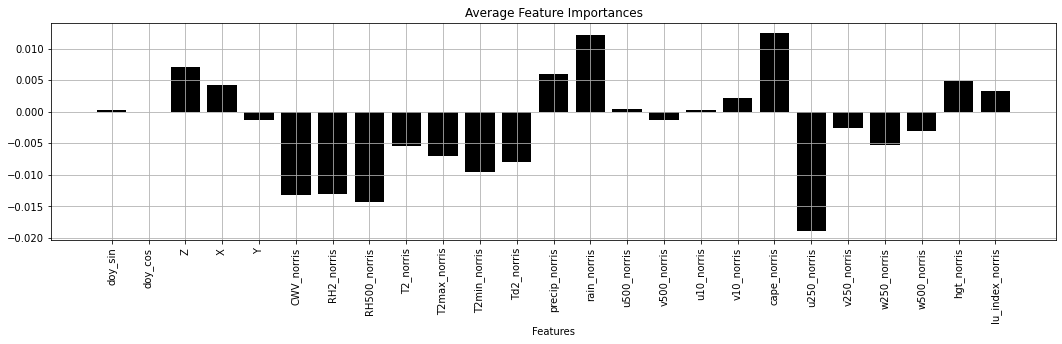

Alpha


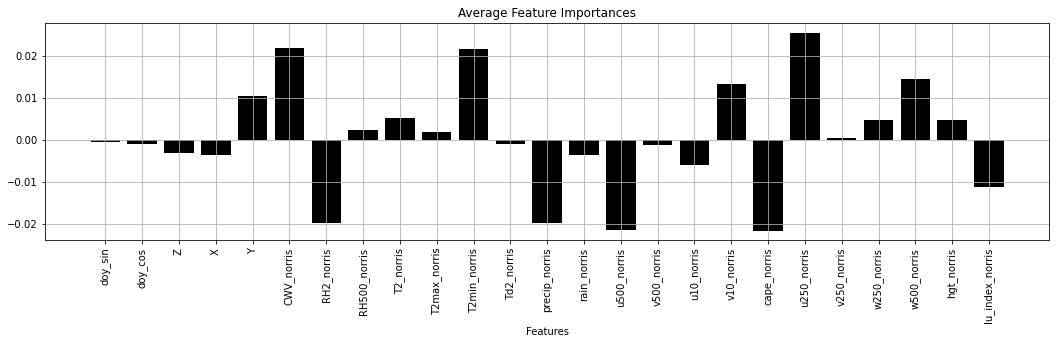

Beta


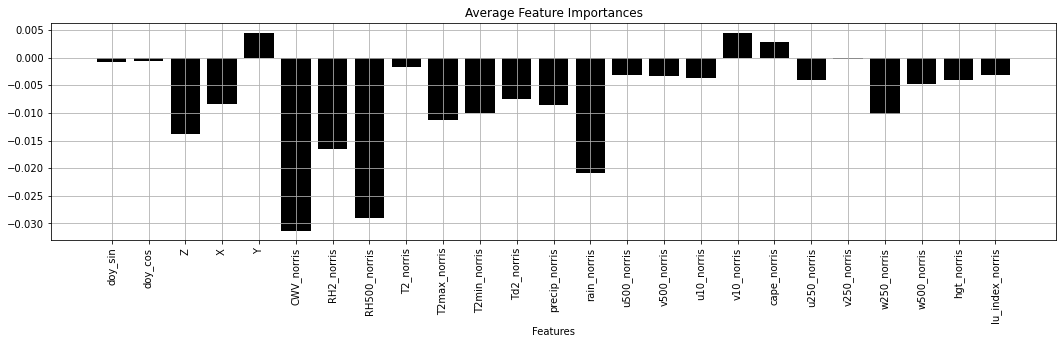

In [13]:
print('Pi')
visualize_importances(CONFIG.predictors, importance['MLP_[10]_bgmm_B=128_D=0']['k_all']['0'])
print('Alpha')
visualize_importances(CONFIG.predictors, importance['MLP_[10]_bgmm_B=128_D=0']['k_all']['1'])
print('Beta')
visualize_importances(CONFIG.predictors, importance['MLP_[10]_bgmm_B=128_D=0']['k_all']['2'])

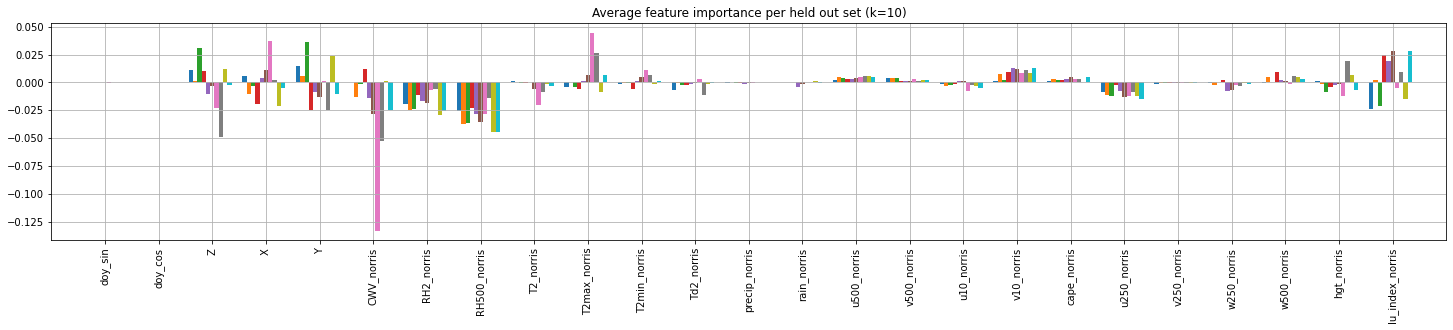

In [19]:
plot_multiple_bars([importance['VGLM_[]_bgmm_B=128_D=0'][f'k{i}']['0'] for i in range(10)], CONFIG.predictors)

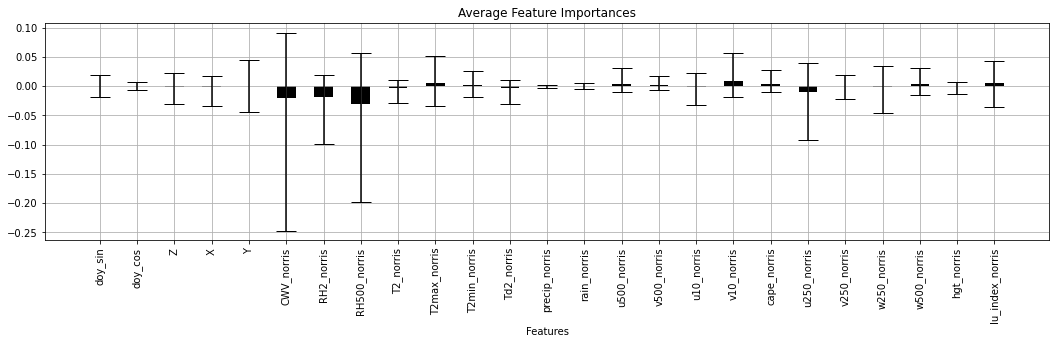

In [17]:
visualize_importances(CONFIG.predictors, importance['VGLM_[]_bgmm_B=128_D=0']['k_all']['0'], plot_error_bars=True)
# visualize_importances(CONFIG.predictors, importance['VGLM_[]_bgmm_B=128_D=0']['k_all']['1'])
# visualize_importances(CONFIG.predictors, importance['VGLM_[]_bgmm_B=128_D=0']['k_all']['2'])

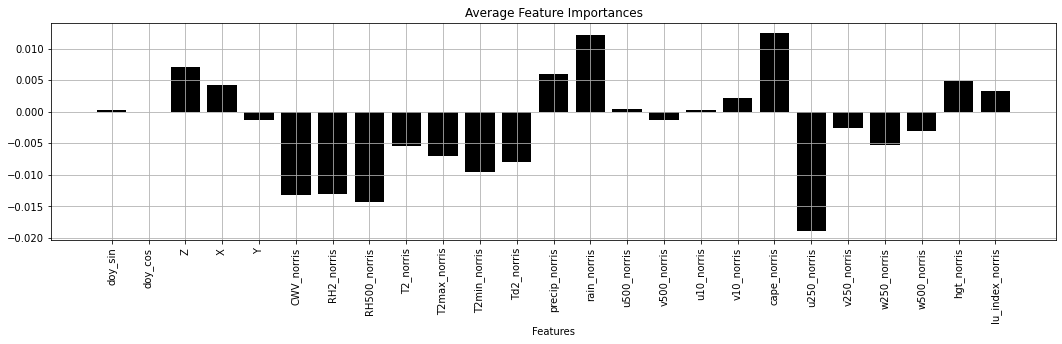

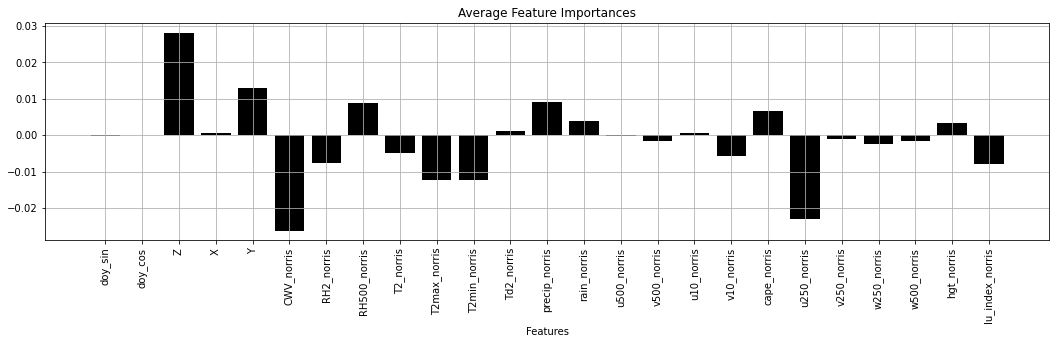

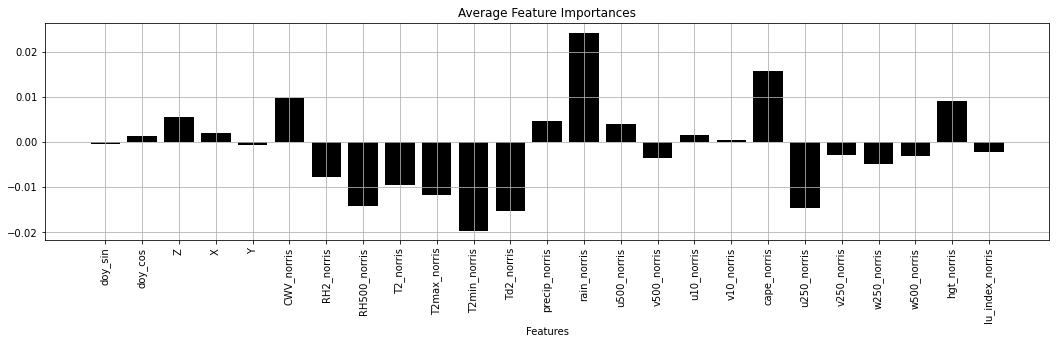

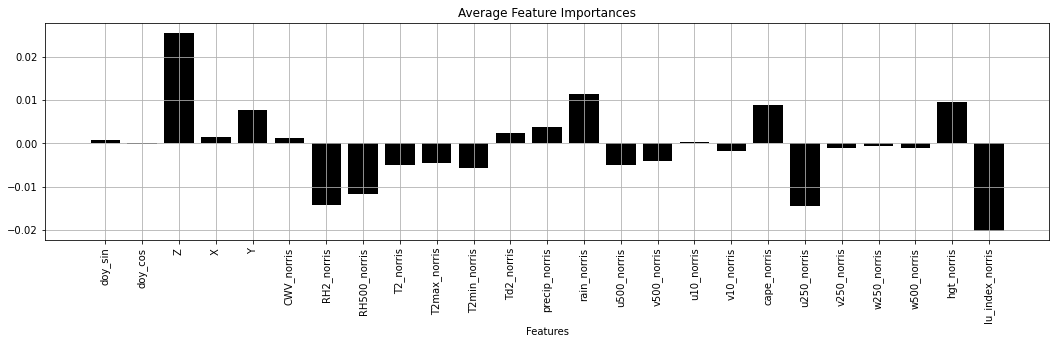

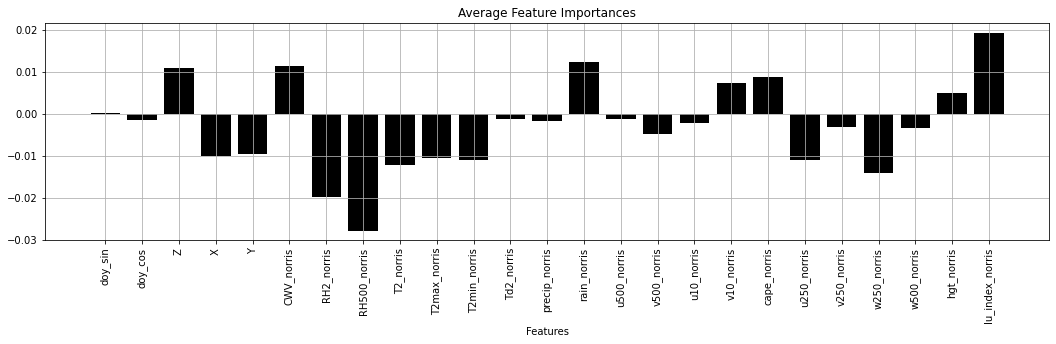

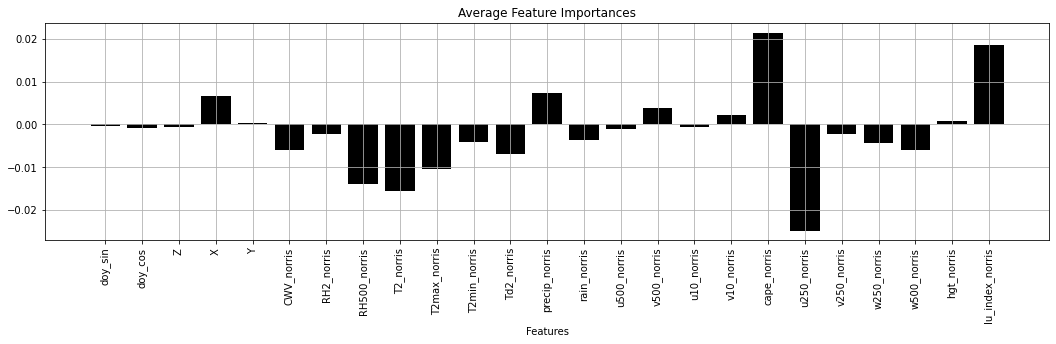

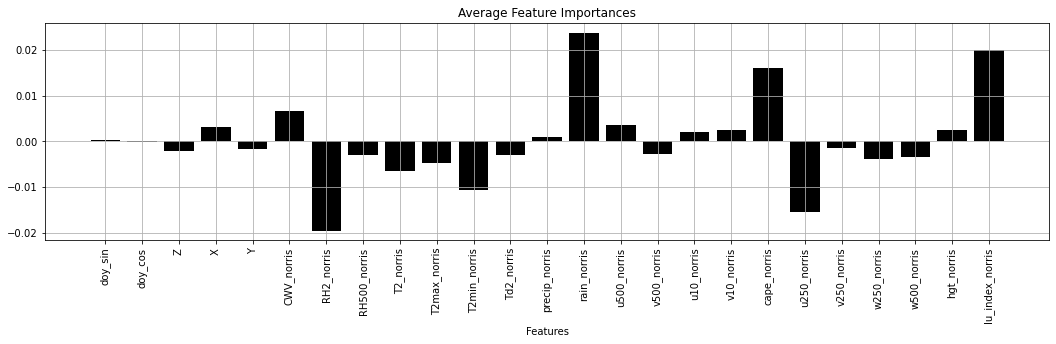

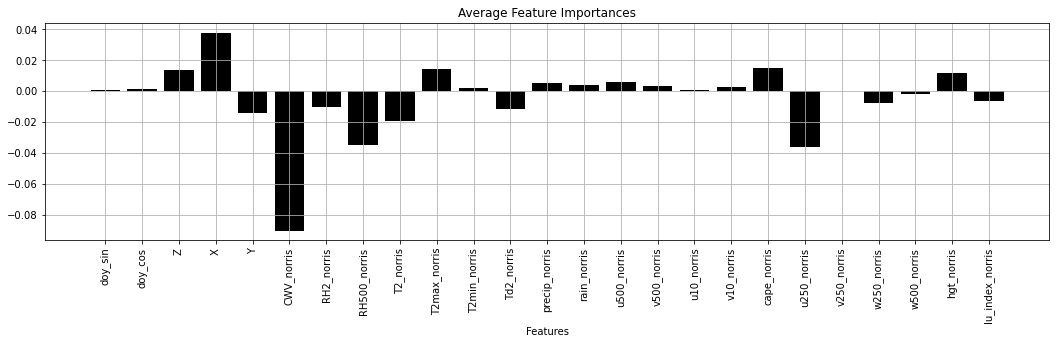

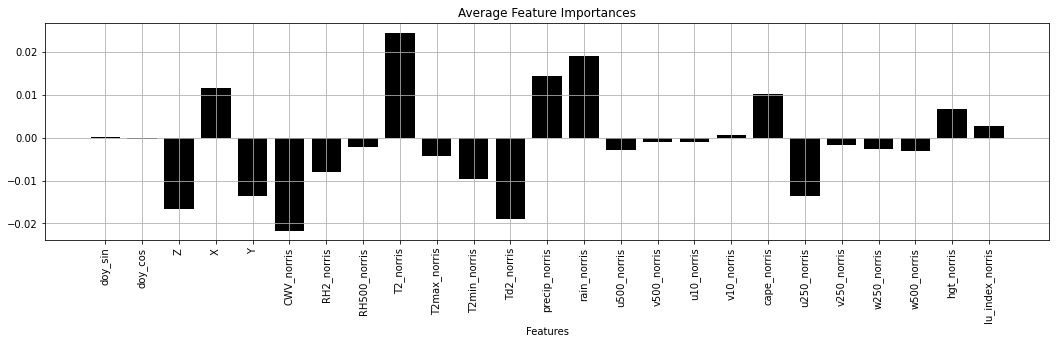

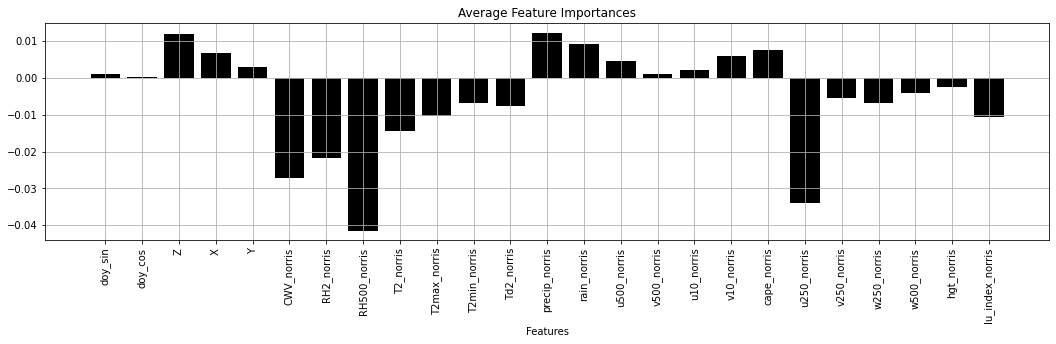

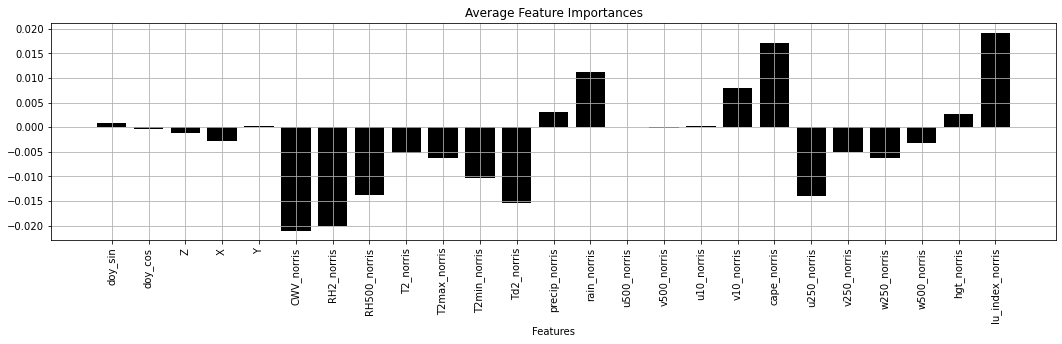

In [199]:
visualize_importances(CONFIG.predictors, importance['MLP_[10]_bgmm_B=128_D=0']['k_all']['0'])
for i in range(10):
    visualize_importances(CONFIG.predictors, importance['MLP_[10]_bgmm_B=128_D=0'][f'k{i}']['0'])
    
# visualize_importances(CONFIG.predictors, importance['MLP_[10]_bgmm_B=128_D=0']['k_all']['1'])
# visualize_importances(CONFIG.predictors, importance['MLP_[10]_bgmm_B=128_D=0']['k_all']['2'])